Consider an unknown univariate function $f \colon [0, \infty) \to \mathbb{R}$, where beliefs about $f(t)$ for $t \geq 0$ are described by a zero-mean Gaussian process, $f \sim \text{GP}(0, k)$, where the covariance kernel $k$ is the periodic kernel,

$$
k(t, t') = \alpha^2 \exp \left( -\frac{2 \sin^2 \left( \pi \lvert t - t' \rvert / p \right)}{\ell^2} \right),
$$

with known period $p > 0$, but unknown magnitude and length scale parameters, $\alpha > 0$ and $\ell > 0$, respectively.

Further suppose $n$ noisy observations $\pmb{y} = (y_1, \ldots, y_n)$ of the function are obtained at corresponding domain points $\pmb{t} = (t_1, \ldots, t_n)$, such that independently

$$
y_i \sim \text{Normal}(f(t_i), \sigma^2), \quad i = 1, \ldots, n,
$$

with an unknown standard deviation $\sigma > 0$.

For a Bayesian analysis of this Gaussian process model, suppose the following independent prior distributions for the three unknown parameters $(\alpha, \ell, \sigma)$:

$$
\alpha \sim \text{Gamma}(0.01, 0.01), \quad \ell \sim \text{Gamma}(0.01, 0.01), \quad \sigma^2 \sim \text{Inverse-Gamma}(100, 1),
$$

parameterised such that if $x \sim \text{Gamma}(a, b)$ then $x$ has probability density function $p(x) \propto \mathbb{1}_{[0, \infty)}(x) x^{a-1} e^{-bx}$ and $x^{-1} \sim \text{Inverse-Gamma}(a, b)$.

We have that

$$
y_i = f ( t_i ) + \epsilon_i,
$$

where $\epsilon_i \sim \text{Normal} (0, \sigma^2)$.

**Mean of $\pmb{y}$**

$$
\mathbb{E} (y_i) = \mathbb{E} \{ f(t_i) + \epsilon_i \}
= \mathbb{E} \{ f(t_i) \} + \mathbb{E} ( \epsilon_i )
= 0
$$

$$
\implies \mathbb{E} (\pmb{y}) = \pmb{0}
$$

**Covariance of $\pmb{y}$**

$$
\text{Cov} (y_i, y_j) = \text{Cov} \{ f(t_i) + \epsilon_i, f(t_j) + \epsilon_j \}
$$

$$
\implies \text{Cov} (y_i, y_j) = \text{Cov} ( \epsilon_i, \epsilon_j ) + \text{Cov} \{ f(t_i), f(t_j) \} + \text{Cov} \{ f(t_i), \epsilon_j \} + \text{Cov} \{ \epsilon_i, f(t_j) \}
$$

Since $\epsilon_i$ and $\epsilon_j$  are independent for all $i \neq j$,

$$
\text{Cov} ( \epsilon_i, \epsilon_j ) = \sigma^2 \mathbb{1}_{\{i=j\}}.
$$

By definition, 

$$
\text{Cov} \{ f(t_i), f(t_j) \} = k(t_i, t_j).
$$

Since $f(t_i)$ and $\epsilon_j$ are independent for all $i$, $j$,

$$
\text{Cov} \{ f(t_i), \epsilon_j \} = \text{Cov} \{ \epsilon_i, f(t_j) \} = 0.
$$

Putting it all together,

$$
\text{Cov} (y_i, y_j) = \sigma^2 \mathbb{1}_{\{i=j\}} + k(t_i, t_j).
$$

Therefore,

$$
\pmb{y} \mid \pmb{t}, \alpha, l, \sigma \sim \text{Normal}_n \left( \pmb{0}, \sigma^2 I_n + K \right),
$$

where $K$ is the covariance kernel matrix satisfying $K_{ij} = k(t_i, t_j)$.

I will write Stan code for performing Bayesian posterior inference for the three unknown parameters $(\alpha, \ell, \sigma)$ given noisy observations $\pmb{y}$ at domain points $\pmb{t}$ and a known period $p$.

In [1]:
gp_model = """
functions {
  matrix periodic_cov(array[] real t1, array[] real t2, real alpha, real l, real p) {
    int n1 = num_elements(t1);
    int n2 = num_elements(t2);
    matrix[n1, n2] cov;
    for (i in 1:n1) {
      for (j in 1:n2) {
        cov[i, j] = alpha^2 * exp(-2 * (sin(pi() * abs(t1[i] - t2[j]) / p))^2 / l^2);
      }
    }
    return cov;
  }
}

data {
  int<lower=0> n;                   // number of observations
  array[n] real<lower=0> t;         // domain points
  vector[n] y;                      // observed data
  real<lower=0> p;                  // period
  int<lower=0> m;                   // number of grid points
  array[m] real<lower=0> t_grid;    // vector of grid points
}

transformed data {
  vector[n] mu = rep_vector(0, n);
}

parameters {
  real<lower=0> alpha;
  real<lower=0> l;
  real<lower=0> sigma;
}

transformed parameters {
  matrix[n, n] Sigma = sigma^2 * diag_matrix(rep_vector(1, n)) + periodic_cov(t, t, alpha, l, p);
}

model {
  y ~ multi_normal(mu, Sigma);
  alpha ~ gamma(0.01, 0.01);
  l ~ gamma(0.01, 0.01);
  sigma^2 ~ inv_gamma(100, 1);
}

generated quantities {
  vector[n] Ky = inverse_spd(Sigma) * y;
  vector[m] fn_vals = periodic_cov(t_grid, t, alpha, l, p) * Ky;
  vector[n] y_rep = multi_normal_rng(mu, Sigma);
  real ppp = multi_normal_lpdf(y | mu, Sigma) >= multi_normal_lpdf(y_rep | mu, Sigma) ? 1 : 0;
}
"""

The file $\texttt{England.txt}$ shows monthly maximum temperatures in England, measured in degrees Celsius, from the Met Office UK and regional series data repository.

In [2]:
import stan
import nest_asyncio
nest_asyncio.apply()

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
# Load the data
data = pd.read_csv('data/England.txt', sep='\s+', skiprows=5).iloc[:, :13]
data_filtered = data[(data['year'] >= 2000) & (data['year'] <= 2004)]
data_long = data_filtered.melt(id_vars='year', var_name='month', value_name='maximum_temperature')
data_long['date'] = pd.to_datetime(data_long['year'].astype(str) + data_long['month'], format='%Y%b')
data_long = data_long.sort_values('date')

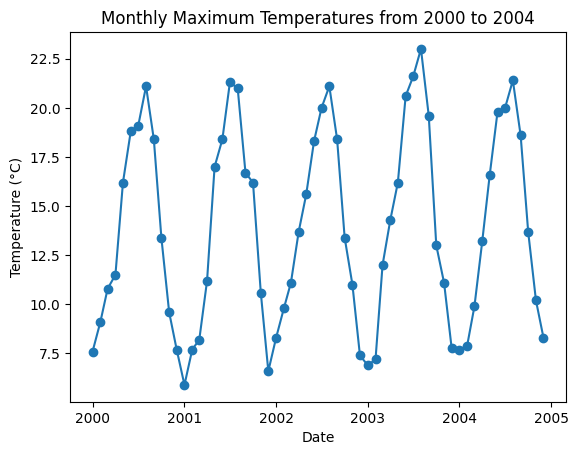

In [4]:
# Plot the data
plt.figure()
plt.plot(data_long['date'], data_long['maximum_temperature'], marker='o')
plt.title('Monthly Maximum Temperatures from 2000 to 2004')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.show()

The periodic kernel assumes that the monthly maximum temperature repeats with a known period. This is appropriate as the monthly maximum temperature appears to repeat every 12 months.

The periodic kernel assumes that the function varies smoothly within each period. This is appropriate as the monthly maximum temperature appears to vary smoothly month-to-month within each 12 month period.

The one potential issue is that there appears to be a very gradual upward trend in the monthly maximum  temperature from 2000 and 2004. The period kernel will not capture this.

In [ ]:
# Cleared cell output in the interest of conciseness

# Data preparation
t = np.arange(1/12, 61/12, 1/12)
n = len(t)
y = data_long['maximum_temperature'].to_numpy()
p = 1
t_grid = np.linspace(0, 5, 100)  # Define a grid of points for regression function evaluation
m = len(t_grid)

# Data dictionary for Stan
sm_data = {'n': n, 't': t, 'y': y, 'p': p, 'm': m, 't_grid': t_grid}

# Build Stan object for model
sm = stan.build(gp_model, data=sm_data, random_seed=1)

# Set number of MCMC chains and iterations, then sample
chains, samples, burn = 1, 10000, 5000
fit = sm.sample(num_chains=chains, num_samples=samples, num_warmup=burn, save_warmup=False)

In [6]:
def plot_samples(fit, par, name):
    fig, axs = plt.subplots(1, 2, figsize=(10,3), constrained_layout=True)
    for i in range(2):
        axs[i].autoscale(enable=True, axis='x', tight=True)
    axs[0].set_title('Estimated marginal posterior density of ' + name)
    axs[1].set_title('Convergence of chain posterior mean estimates for ' + name)
    par_mx = fit[par].reshape(samples, chains)
    posterior_mean = np.mean(par_mx)
    print(f'Estimated posterior mean value for {par}: {posterior_mean}')
    axs[0].hist(par_mx.flatten(), 200, density=True)
    for i in range(chains):
        x = i * samples + np.arange(samples)
        axs[1].plot(x, np.cumsum(par_mx[:, i]) / range(1, samples + 1))
    plt.show()

Estimated posterior mean value for alpha: 21.034290633880893


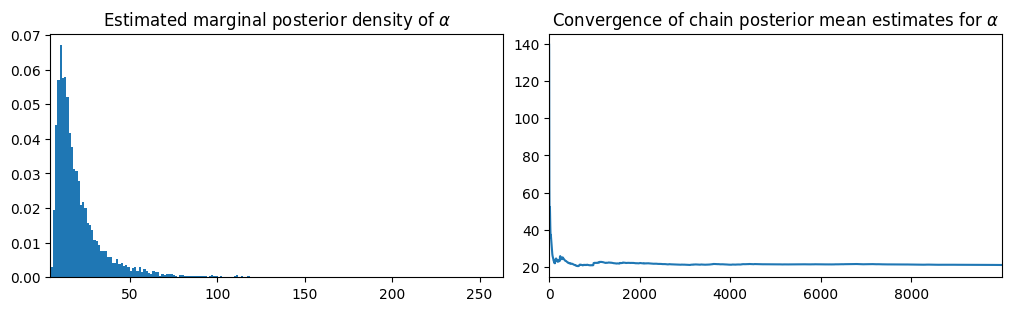

In [7]:
plot_samples(fit, 'alpha', r'$\alpha$')

Estimated posterior mean value for l: 3.542394164436673


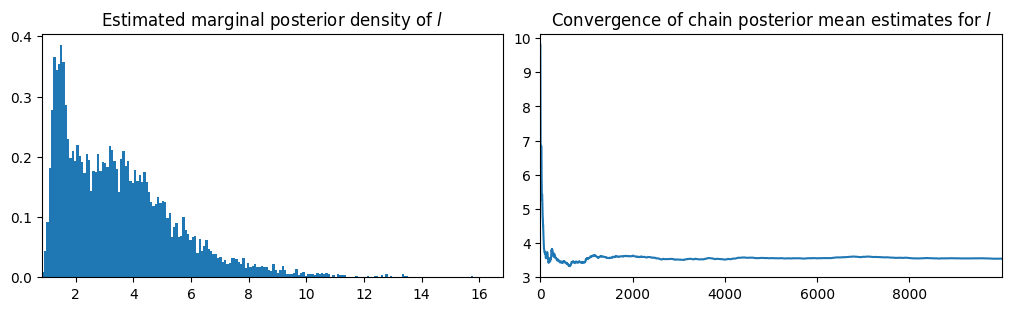

In [8]:
plot_samples(fit, 'l', r'$l$')

Estimated posterior mean value for sigma: 0.47063979863883887


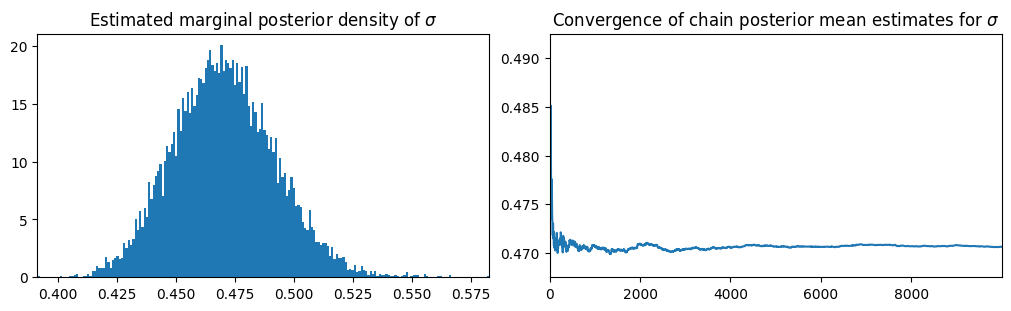

In [9]:
plot_samples(fit, 'sigma', r'$\sigma$')

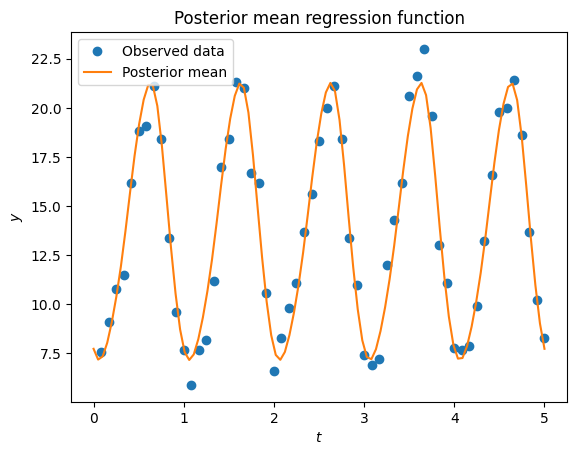

In [10]:
f = np.mean(fit['fn_vals'], axis=1)

# Plot the results
plt.figure()
plt.plot(t, y, 'o', label='Observed data')
plt.plot(t_grid, f, label='Posterior mean')
plt.title('Posterior mean regression function')
plt.ylabel(r'$y$')
plt.xlabel(r'$t$')
plt.legend()
plt.show()

The Monte Carlo estimate of the mean regression function fits the data reasonably well. Crucially, the fit captures the periodicity of the data. However, as mentioned in my answer to part i., the very gradual upward trend in the data is not captured.

I will calculate a posterior predictive $p$-value using the negative log-likelihood function for the likelihood model.

In [11]:
samples_ppp = fit['ppp']
mean_ppp = np.mean(samples_ppp)
print(f'Posterior predictive p-value: {mean_ppp}')

Posterior predictive p-value: 0.0


The resampled data always had higher likelihood than the original data, suggesting a poor model fit.